# Navigation

---

In the following we will train a Double Q-learning agent to _solve_ the unity banana environment. We will start out starting the environment, then just have a run of random actions. 
Then move on to train the double DQN (Double Q-learning agent), by simulating it in the banana environment. 

The training is set to continue for 2000 episodes or until the average reward for a 100 episodes is above 13, in which case the agent is said to solve the environment. 

In the following we will: 
1. Start the environment - load the unity environment, ready to simulate
2. Examine the State and Action Spaces - have a look at the environment. 
3. Train the Double DQN agent - initialize and train our RL agent in the unity environment.

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run! (This assumes that the instructions in the README.md was follwed). 

In [1]:
#!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="data/Banana")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Train the Double DQN agent!

The implementation of the agent is found in the `dqn_agent.py` file in the same folder, it uses the pytorch model defined in `model.py` and replay memory implemented in `replay_memory.py`.

First import the modules mentioned above, alont with (Py)torch. Then we set a list of hyper parameters, which help define the agent we will train. 

In [5]:
from dqn_agent import DqnAgent
from replay_memory import ReplayMemory
from collections import deque

import torch

LR = 5e-4            # Neural network learning rate. 
BUFFER_SIZE = 30000  # replay memory size
BATCH_SIZE = 64      # minibatch size
GAMMA = 0.99         # discount factor
TAU = 1e-3           # for soft update of target parameters
UPDATE_EVERY = 3     # how often should the network be updated.

SEED = 42            # seed for the random module, such that we can repeat the experiment. 

n_episodes=2000      # max number of episodes.
max_t=1000           # max number of steps in an episode. 
eps_start=1.0        # Epsilon to start out with. This means 100% exploration in the beginning
eps_end=0.1          # Epsilon we will end with. After a while the agent will only explore 10% of the time
eps_decay=0.99       # indicates how quickly epsilon should go to the end espilon
alpha=0.6            # learning rate
beta0=0.1            # Anneiling rate
beta_rate=0.99992    # decay of anealing. 

First we create the agent, using the parameters defined above. The agent creates two networks which are defined to have 2 layers with 64 hidden notes each. 

In [6]:
agent = DqnAgent(state_size,
                 action_size,
                 ReplayMemory(action_size, BUFFER_SIZE, BATCH_SIZE, SEED, alpha, beta0, beta_rate),
                 SEED)
env_info = env.reset(train_mode=True)[brain_name] # reset the environment

To simulate the agent collecting bananas run the following cell. 

In [7]:
scores = []
scores_window = deque(maxlen=100)
epsilon = eps_start

for i_episode in range(1, n_episodes + 1):

    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    action_values = np.zeros(1)

    for t in range(max_t):

        action, action_values = agent.act(state, epsilon)

        env_info = env.step(action)[brain_name]  # send the action to the environment
        next_state = env_info.vector_observations[0]  # get the next state
        reward = env_info.rewards[0]  # get the reward
        done = env_info.local_done[0]  # get the done status

        agent.step(state, action, reward, next_state, done)

        state = next_state
        score += reward

        if done:
            break

    scores_window.append(score)
    scores.append(score)

    epsilon = max(eps_end, epsilon * eps_decay)

    log_str = '\rEpisode {}\tAverage Score: {:.2f} \tbeta: {:.2f}\taction_value: {:.2f}'
    print(log_str.format(i_episode, np.mean(scores_window), agent.memory.beta, action_values.mean()), end="")

    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window) >= 13.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100,
                                                                                     np.mean(scores_window)))
        torch.save(agent.qnet_local.state_dict(), 'checkpoint.pth')
        break

Episode 100	Average Score: 0.76 	beta: 0.22	action_value: 0.25
Episode 200	Average Score: 6.55 	beta: 0.49	action_value: 0.57
Episode 300	Average Score: 12.09 	beta: 1.00	action_value: 1.74
Episode 364	Average Score: 13.01 	beta: 1.00	action_value: 1.03
Environment solved in 264 episodes!	Average Score: 13.01


The training terminated after 264 episodes with which means that for the last 100 episodes the agent
on average recieved more than 12 in reward. The following plot shows how the rewards was distributed. 


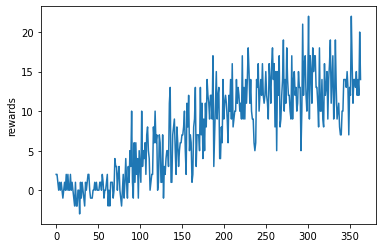

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(scores)
plt.ylabel('rewards')
plt.show()


In [10]:
plt.savefig('images/rewards.png')

<Figure size 432x288 with 0 Axes>